In [1]:
import numpy as np
import pandas as pd
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# sklearn 에서 제공하는 20개의 다른 주제를 가진 뉴스그룹 데이터 사용
newsdata = fetch_20newsgroups(subset='train')

In [3]:
print(newsdata.keys())
# 해당 데이터의 속성 정보

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [4]:
print('훈련용 샘플 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플 개수 : 11314


In [5]:
len(newsdata.target_names) # 20개 카테고리

20

In [6]:
newsdata.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [7]:
print(newsdata.target)
# label이 0 ~ 19
print('label 최댓값 :', max(newsdata.target))
print('label 최솟값 :', min(newsdata.target))

[7 4 4 ... 3 1 8]
label 최댓값 : 19
label 최솟값 : 0


In [8]:
print(newsdata.target[0])
print(newsdata.data[0])

7
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [9]:
# 데이터 탐색

data = pd.DataFrame(newsdata.data, columns=['email'])
data['target'] = pd.Series(newsdata.target)
data[:10]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16
6,From: bmdelane@quads.uchicago.edu (brian manni...,13
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4


In [10]:
data['target'].value_counts()

10    600
15    599
8     598
9     597
11    595
7     594
13    594
5     593
14    593
2     591
12    591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: target, dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB


In [12]:
# 결측값 확인

print('결측값 여부 :', data.isnull().values.any())

결측값 여부 : False


In [13]:
data['email'].nunique()
# 중복을 제외한 샘플 개수

11314

In [14]:
data['target'].nunique()
# 중복을 제외한 카테고리 수

20

<Axes: >

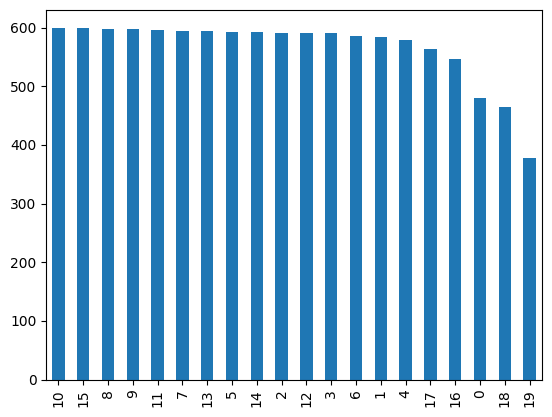

In [15]:
# 데이터 균일 여부 확인 >> 데이터 시각화

data['target'].value_counts().plot(kind = 'bar')

In [16]:
print(data.groupby('target').size().reset_index(name='count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [17]:
# 데이터 분리

newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)

In [18]:
train_email = data['email']
train_label = data['target']

test_email = newsdata_test.data
test_label = newsdata_test.target

In [19]:
print(train_email[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [20]:
# TF-IDF 전처리

vocab_size = 10000

tfidf_vect = TfidfVectorizer(max_features=vocab_size)
train_tfidf_list = tfidf_vect.fit_transform(train_email).toarray().tolist()

In [21]:
test_tfidf_list = tfidf_vect.fit_transform(test_email).toarray().tolist()

In [22]:
print('훈련 데이터의 TF-IDF 행렬 크기 :', np.shape(train_tfidf_list))
print('훈련 데이터의 TF-IDF 행렬 크기 :', np.shape(test_tfidf_list))

훈련 데이터의 TF-IDF 행렬 크기 : (11314, 10000)
훈련 데이터의 TF-IDF 행렬 크기 : (7532, 10000)


In [34]:
train_tfidf_tensor = torch.tensor(train_tfidf_list)
train_label_tensor = torch.tensor(train_label)

test_tfidf_tensor = torch.tensor(test_tfidf_list)
test_label_tensor = torch.tensor(test_label)

In [35]:
print(train_tfidf_tensor.shape)
print(train_label_tensor.shape)
print(test_tfidf_tensor.shape)
print(test_label_tensor.shape)

torch.Size([11314, 10000])
torch.Size([11314])
torch.Size([7532, 10000])
torch.Size([7532])


In [36]:
# MLP (다층 퍼셉트론)

# 모델 설계

# 뉴런 : 1400 개의 은닉층

class Perceptron(torch.nn.Module) :
    
    # nn.Module 을 상속 받음.
    # __init__() : 모델의 구조와 동작을 정의, 생성자
    # super() 함수 호출 : 상속받아 속성을 초기화
    def __init__(self, tfidf_size, num_label) :
        super(Perceptron, self).__init__()
        self.linear1 = torch.nn.Linear(tfidf_size, 1400)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1400, num_label)
    
    # 모델이 학습 데이터 입력 받아 forward 연산 진행시키는 함수
    # model 객체 생성 >> model(입력 데이터) >> 연산 수행
    def forward(self, tfidf_input) :
        hidden = self.linear1(tfidf_input)
        relu = self.relu(hidden)
        y_pred = self.linear2(relu)
        return y_pred

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_labels = len(newsdata.target_names)

model = Perceptron(tfidf_size = vocab_size, num_label = num_labels)

model.to(device)

Perceptron(
  (linear1): Linear(in_features=10000, out_features=1400, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=1400, out_features=20, bias=True)
)

In [38]:
# 손실함수 (cost function)
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [39]:
# 데이터 로더를 사용하기 위해서는 TensorDataset 데이터셋 형식으로 변환해 준다.
# 데이터 로더를 사용하는 이유 : 1개씩 넣는 것이 아니라 n개씩 병렬처리 해 주는 도구
# 데이터 로더는 기본적으로 2개의 인자를 받음(dataset, mini_batch_size)
# shuffle 인자도 많이씀

train_dataset = torch.utils.data.TensorDataset(train_tfidf_tensor, train_label_tensor)
test_dataset = torch.utils.data.TensorDataset(test_tfidf_tensor, test_label_tensor)

In [40]:
# 미니배치 크기 일반적으로 2배 수로 늘려줌

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True)
# batch_szie = 4 : 4개씩 묶인 데이터
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True)

In [44]:
model.train(True)
model.zero_grad()

for epoch in range(5) :
    epoch_loss = 0
    for batch in train_dataloader :
        batch = tuple(t.to(device) for t in batch)
        y_pred = model(batch[0])
        loss = criterion(y_pred, batch[1].type(torch.LongTensor).to(device))
        epoch_loss += loss.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    print(epoch, epoch_loss)

model.train(False)

0 1827.3281165386397
1 138.5409916004678
2 52.98265794237303
3 42.48480984748355
4 30.863839261655528


Perceptron(
  (linear1): Linear(in_features=10000, out_features=1400, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=1400, out_features=20, bias=True)
)

In [52]:
model.eval()
pred = None
lable = None

for batch in test_dataloader :
    batch = tuple(t.to(device) for t in batch)
    
    with torch.no_grad() :
        y_pred = model(batch[0])
        
    if pred is None :
        pred = y_pred.detach().cpu().numpy()
        label = batch[1].detach().cpu().numpy()
    
    else :
        pred = np.append(pred, y_pred.detach().cpu().numpy(), axis=0)    
        label = np.append(label, batch[1].detach().cpu().numpy(), axis = 0)
        
pred = np.argmax(pred, axis =1)       

    

In [53]:
print('Macro average precision :',round(precision_score(test_label, pred, average='macro')*100, 4))
print('Micro average precision :',round(precision_score(test_label, pred, average='micro')*100, 4))

Macro average precision : 5.0028
Micro average precision : 5.324


In [54]:
print('Macro average recall :',round(recall_score(test_label, pred, average='macro')*100, 4))
print('Micro average recall :',round(recall_score(test_label, pred, average='micro')*100, 4))

Macro average recall : 5.1844
Micro average recall : 5.324


In [55]:
print('Macro average f1 :',round(f1_score(test_label, pred, average='macro')*100, 4))
print('Micro average f1 :',round(f1_score(test_label, pred, average='micro')*100, 4))

Macro average f1 : 4.2955
Micro average f1 : 5.324


In [5]:
import numpy as np
keep = np.ones(5, dtype=bool)
keep

array([ True,  True,  True,  True,  True])

In [7]:
for idx, i in enumerate(keep) :
    print(idx, i)

0 True
1 True
2 True
3 True
4 True


In [21]:
a = [True, False] * 5
for idx, bo in enumerate(a) :
    if not bo :
        continue
    print(idx, bo)

0 True
2 True
4 True
6 True
8 True


In [20]:
True

-2